In [1]:
# Numpy
import numpy as np
from typing import List

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress
from rich.progress import Progress, SpinnerColumn, TimeElapsedColumn, TextColumn
#from sklearn.metrics import confusion_matrix

# Helpers
from src.helpers.load_data import mnist
from src.helpers.plot import plot_examples, plot_layers
from src.helpers.data_transforms import normalize

%config InlineBackend.figure_format = "retina"

## Multilayer FeedForward Network

In this notebook I will implement a feed forward network with hidden layers, sigmoid and leaky relu activation functions and a He initialization for the weights. I will use again the MNIST dataset as in the previous notebook. 

In [2]:
train_images, train_labels, test_images, test_labels = mnist()

Dataset MNIST
    Number of datapoints     
    Train:  60000
    Test:   10000
    Source: https://ossci-datasets.s3.amazonaws.com/mnist/



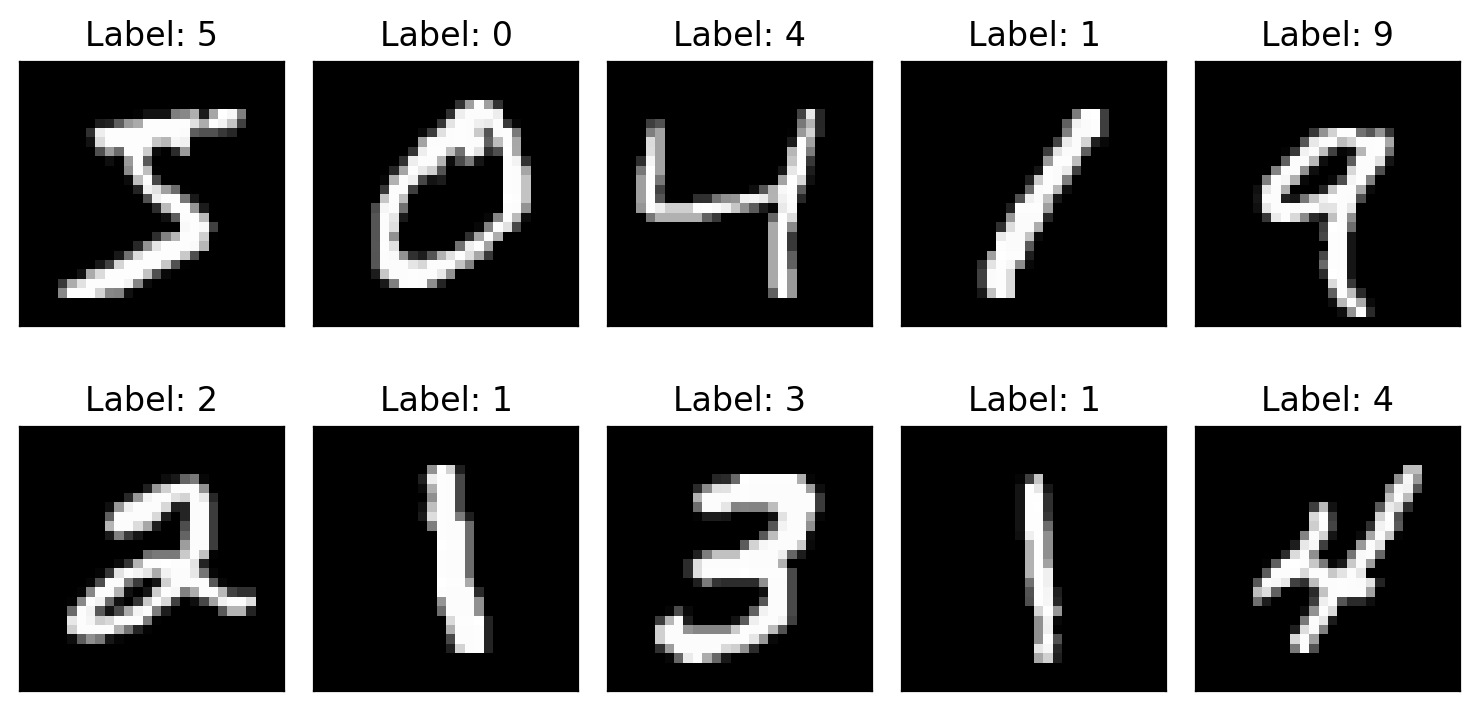

In [3]:
# inspect image data as it is
plot_examples(train_images, train_labels)

In [4]:
# inspect a single image

with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(np.asarray(train_images[0]))

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253. 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.]

## Preperation

as data preperation I will one-hot encode the labels and normalize the data. Therefore I will use the same normalization as for the perceptron, but import the function from the helpers module. As a last data preperation step I will define the function to prepare the batches and another to shuffle the data after each epoch to achieve a more randomized training process.

In [5]:
def one_hot_encoding(
    y: np.ndarray[int], num_labels: int = 10
) -> np.ndarray[np.ndarray[int]]:
    """one_hot_encoding assigns the one hot encoding according to the classes.

    Args:
        y (np.ndarray[int]): np.ndarray of the class labels
        num_labels (int, optional): defines the number of different classes. Defaults to 10.

    Returns:
        np.ndarray[np.ndarray[int]]: the one hot encoding as a vector for each class in the input array
    """
    one_hot = np.zeros(
        (num_labels, y.shape[0]), dtype=np.float16
    )  # TODO: why float16 here, would it be enough to use int.

    for i, val in enumerate(y):
        one_hot[val, i] = 1.0

    return one_hot


def prep_batches(
    X: np.ndarray[np.ndarray[np.ndarray[np.float32]]], y: np.ndarray, batch_size: int = 8
) -> tuple[np.ndarray, np.ndarray]:
    """prep_batches packs the data into desired batch dimension and returns it as a tuple of numpy.ndarray with the image data and the ground truth labels

    Args:
        X (np.ndarray): image data
        y (np.ndarray): class labels

    Returns:
        tuple[np.ndarray]: tuple with the  X and y components packed to desired batch size
    """
    X_ = []
    y_ = []

    itr = len(y) // batch_size + 1 # // -> floor division, +1 -> ceil division to get all batches
    for j in range(1, itr):
        rng = j * batch_size
        X_.append(X[rng - batch_size : rng, :])
        y_.append(y[rng - batch_size : rng])

    X, y = np.array(X_), np.array(y_)

    return X, y


def shuffle_data(X: np.ndarray[np.ndarray[np.ndarray[np.float32]]], y: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """shuffle_data shuffles the data and labels in the same order.

    Args:
        X (np.ndarray): image data
        y (np.ndarray): class labels

    Returns:
        tuple[np.ndarray, np.ndarray]: shuffled image data and corresponding labels
    """
    idx = np.arange(X.shape[0])  
    np.random.shuffle(idx)  
    X = X[idx]  
    y = y[idx]  
    return X, y

## Weight Initialization and bias_units

Next I initalize the weights and bias units. I will use the He * initialization for the weights which increased the accuracy about 4% compared to a random initialization of the weights in combination with a leaky relu activation function. For each layer I will add a bias unit with a value of 1, which ensures that at least this signal is propagated through the network.

In [12]:
# Weight initialization

def init_weight(n_input, n_output, bias_size: int = 1, distr:str = "normal") -> np.ndarray:
    """using He * initialization increases accuracy about 4% with l_relu.
    
    Args:
        n_input (int): number of input neurons
        n_output (int): number of output neurons
        bias_size (int, optional): size of the bias. Defaults to 1.
        distr (str, optional): distribution type. Defaults to "normal". Choices are "normal" or "uniform".

    Returns:
        np.ndarray: weight matrix
    """
    rng = np.random.default_rng() 
    if distr == "normal":
        weight = rng.standard_normal((n_output, n_input + bias_size)) * np.sqrt(2 / n_output)
    elif distr == "uniform":
        weight = rng.uniform(-0.5, 0.5, (n_output, n_input + bias_size)) * np.sqrt(2 / n_output)
    else:
        raise ValueError("Invalid distribution type. Choises are 'normal' or 'uniform'.")
    return weight

def init_weights(layers: list[int], bias_size: int = 1, distr:str = "normal") -> list[np.ndarray]:
    """init_weights initializes the weights of the network.

    Args:
        layers (list[int]): list of the number of neurons in each layer
        bias_size (int, optional): size of the bias. Defaults to 1.
        distr (str, optional): distribution type. Defaults to "normal". Choices are "normal" or "uniform".

    Returns:
        list[np.ndarray]: list of the weights for each layer
    """
    weights = []
    for i in range(len(layers) - 1):
        weight = init_weight(layers[i], layers[i + 1], bias_size, distr)
        weights.append(weight)
    return weights

def add_bias_unit(layer: np.ndarray, bias_size: int = 1) -> np.ndarray:
    """add_bias_unit adds a bias unit to the layer.
    Args:
        layer (np.ndarray): layer (2d) to which the bias unit is added
        bias_size (int, optional): size of the bias. Defaults to 1.
    Returns:
        np.ndarray: layer (2d) with the bias unit added
    """

    updated_layer = np.ones((layer.shape[0] + bias_size, layer.shape[1]))
    updated_layer[1:, :] = layer
   
    return updated_layer

weights = init_weights([784, 256, 128, 10], bias_size=1, distr="normal")

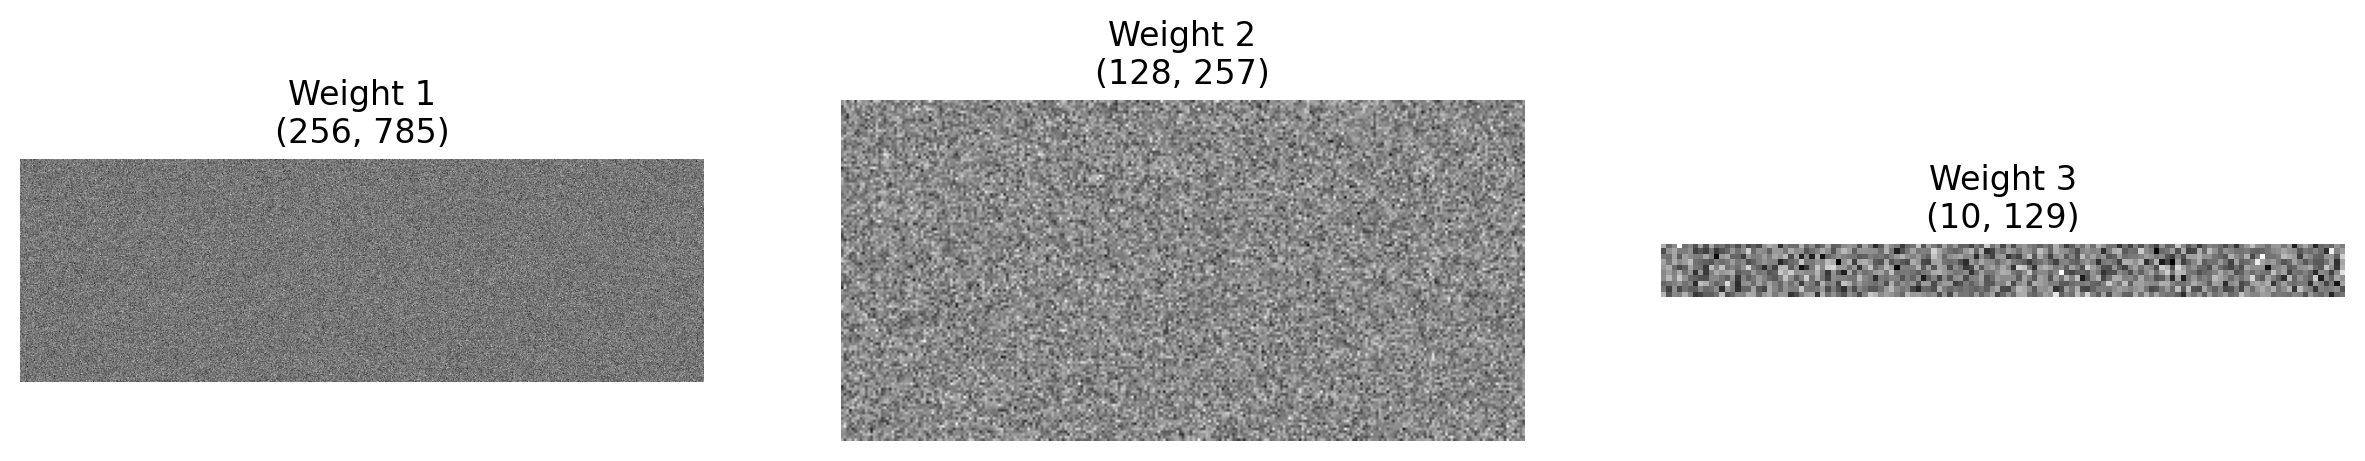

In [15]:
plot_layers({"Weight 1": weights[0], "Weight 2": weights[1], "Weight 3": weights[2]})

## Activation functions

The activation functions define the non-linearities of the network. In other words they define how the signal is propagated through the network. I will compare the leaky relu (simple and effective) and the sigmoid (old school) activation function. Further I need the softmax function as i desire probabilities as the final output. In the following plot you can see that the derivate of the sigmoid has small values, which contributes to the problem of vanishing gradidents in the backpropagation algorithm. The derivate of the leaky relu is either very small or zero, which reduces this problem.

sig: [[0.26894142 0.5        0.73105858]]
sig_diff: [[0.19661193 0.25       0.19661193]]
l_relu: [[-0.2  0.   1. ]]
l_relu_diff: [[0.2 1.  1. ]]
softmax: [[1. 1. 1.]]


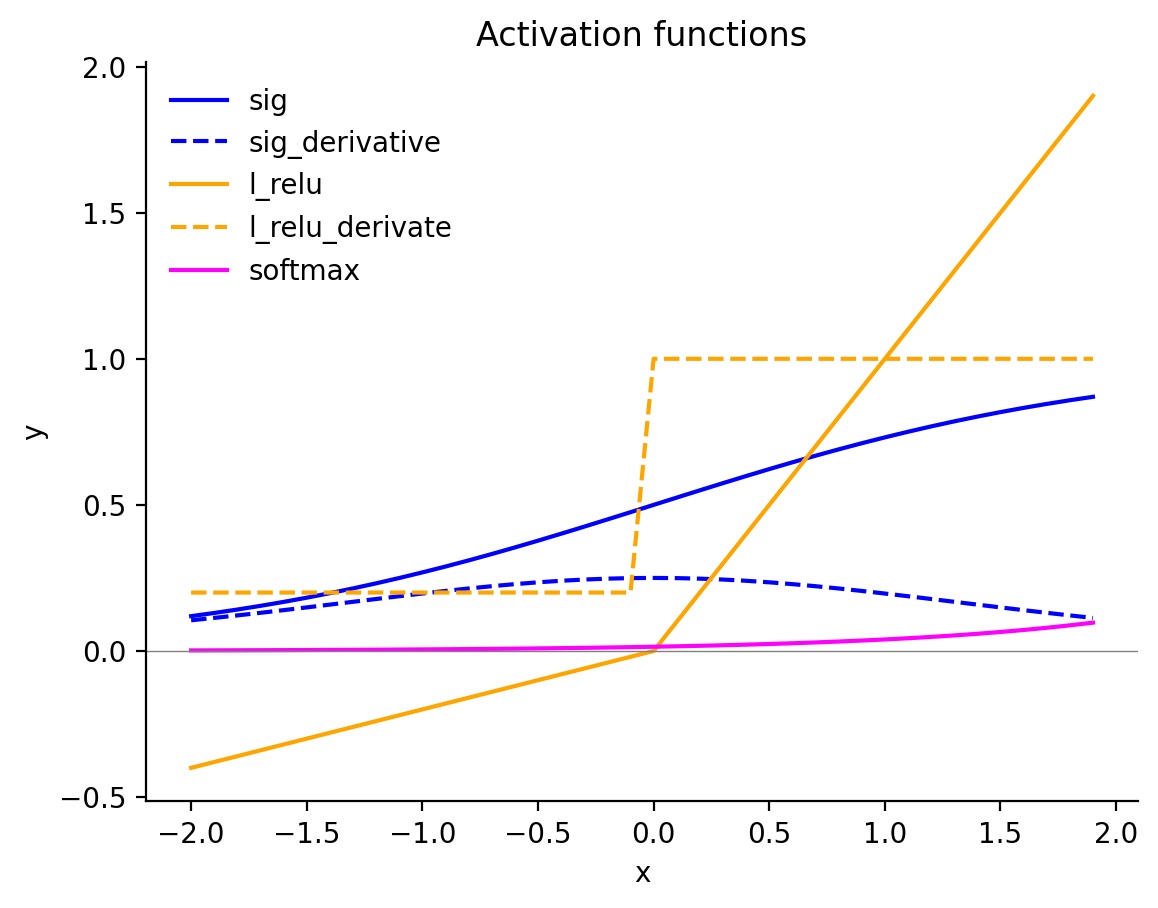

In [16]:
# define and compare activation functions


def l_relu(x: np.ndarray) -> np.ndarray:
    """l_relu is the leaky relu activation function.
    if x < 0, then x = x * 0.2
    if x >= 0, then x = x
    Args:
        x (np.ndarray): input data
    Returns:
        np.ndarray: transformed output data
    """
    _x = x.copy()
    _x[x < 0] = _x[x < 0] * 0.2
    return _x

def l_relu_backward(x: np.ndarray) -> np.ndarray:
    """l_relu_backward is the derivative of the leaky relu activation function.
    if x < 0, then x = 0.2
    if x >= 0, then x = 1
    Args:
        x (np.ndarray): input data
    Returns:
        np.ndarray: transformed output data
    """
    out = np.ones_like(x)
    out[x < 0] *= 0.2
    return out

def sigmoid(x: np.ndarray) -> np.ndarray:
    """sig is the sigmoid activation function.
    follows the formula: 1 / (1 + exp(-x)) (logistic function)
    Args:
        x (np.ndarray): input data
    Returns:
        np.ndarray: transformed output data
    """
    return 1 / (1 + np.exp(-x))

def sig_backward(x):
    """sig_backward is the derivative of the sigmoid activation function.
    follows the formula: sig(x) * (1 - sig(x))
    Args:
        x (np.ndarray): input data
    Returns:
        np.ndarray: transformed output data
    """
    sig_x = sigmoid(x)
    return sig_x * (1 - sig_x)

def softmax(x: np.ndarray) -> np.ndarray:
    """softmax is the softmax activation function.
    follows the formula: exp(x) / sum(exp(x)) and normalizes the output to the range [0, 1] and the sum of all outputs is 1. (Probability distribution)
    Args:
        x (np.ndarray): input data
    Returns:
        np.ndarray: transformed output data
    """
    x = x - np.max(x, axis=0).reshape(x.shape[1])
    x = np.exp(x) / np.sum(np.exp(x), axis=0).reshape(x.shape[1])
    return x


test_array = np.array([[-1.0, 0.0, 1.0]])

print(
    f"sig: {sigmoid(test_array)}\nsig_diff: {sig_backward(test_array)}\nl_relu: {l_relu(test_array)}\nl_relu_diff: {l_relu_backward(test_array)}\nsoftmax: {softmax(test_array)}"
)

example_data = np.arange(-2.0, 2.0, 0.1)
plt.plot(example_data, sigmoid(example_data), color="blue")
plt.plot(example_data, sig_backward(example_data), color="blue", linestyle="--")
plt.plot(example_data, l_relu(example_data), color="orange")
plt.plot(example_data, l_relu_backward(example_data), color="orange", linestyle="--")
plt.plot(example_data, softmax(example_data.reshape(example_data.shape[0], 1)), color="magenta")
plt.title("Activation functions")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color="gray", linewidth=0.5)
# plt.hlines(y=0, xmax=2, xmin=-2, color="grey", linewidth=0.2)
plt.legend(labels=["sig", "sig_derivative", "l_relu", "l_relu_derivate", "softmax"], frameon=False)
sns.despine()
plt.show()

## Forward pass

Now I have all elements created to define the forwardpass of the neural network.

In [20]:
def compute_forward_pass(X: np.ndarray, weights: List[np.ndarray], activation:str ="l_relu", mode: str = "train"):
    # checks
    if activation == 'l_relu':
        a_chosen = l_relu
    elif activation == 'sigmoid':
        a_chosen = sigmoid
    else: 
        raise ValueError("Not implemented activation function. Valid choises are l_relu or sigmoid")

    if mode not in ['train', 'inference']:
        raise ValueError("possible modes are 'train' or 'inference'.")

    # count the layers
    last_layer = len(weights) -1

    # Transpose input that it matches the shape of the weight
    a = X.T
    out = []
    for layer, weight in enumerate(weights):
        a = add_bias_unit(a)
        out.append(a)
        z = np.matmul(weight, a)
        out.append(z)
        if layer == last_layer:
            a = softmax(z)
            out.append(a)
        else:
            a = a_chosen(z)

    return tuple(out) if mode == 'train' else a
        

To test the forward pass I will use a small sample of the MNIST Dataset containing 5 images, that it's easy to differentiate the dimension of the classes 10 and the dimension of the sample 5 and normalize them.

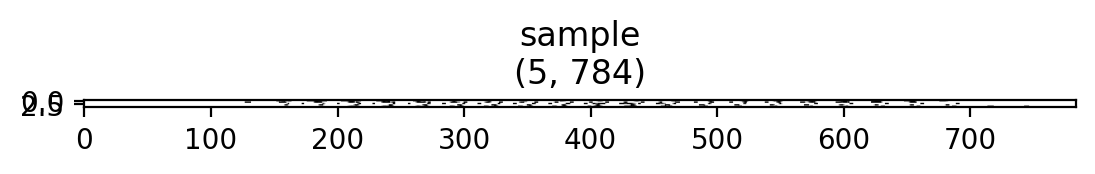

In [21]:
sample = normalize(train_images.reshape(-1, 784)[:5], 0, 1)
label = train_labels[:5]
plot_layers({"sample": sample})

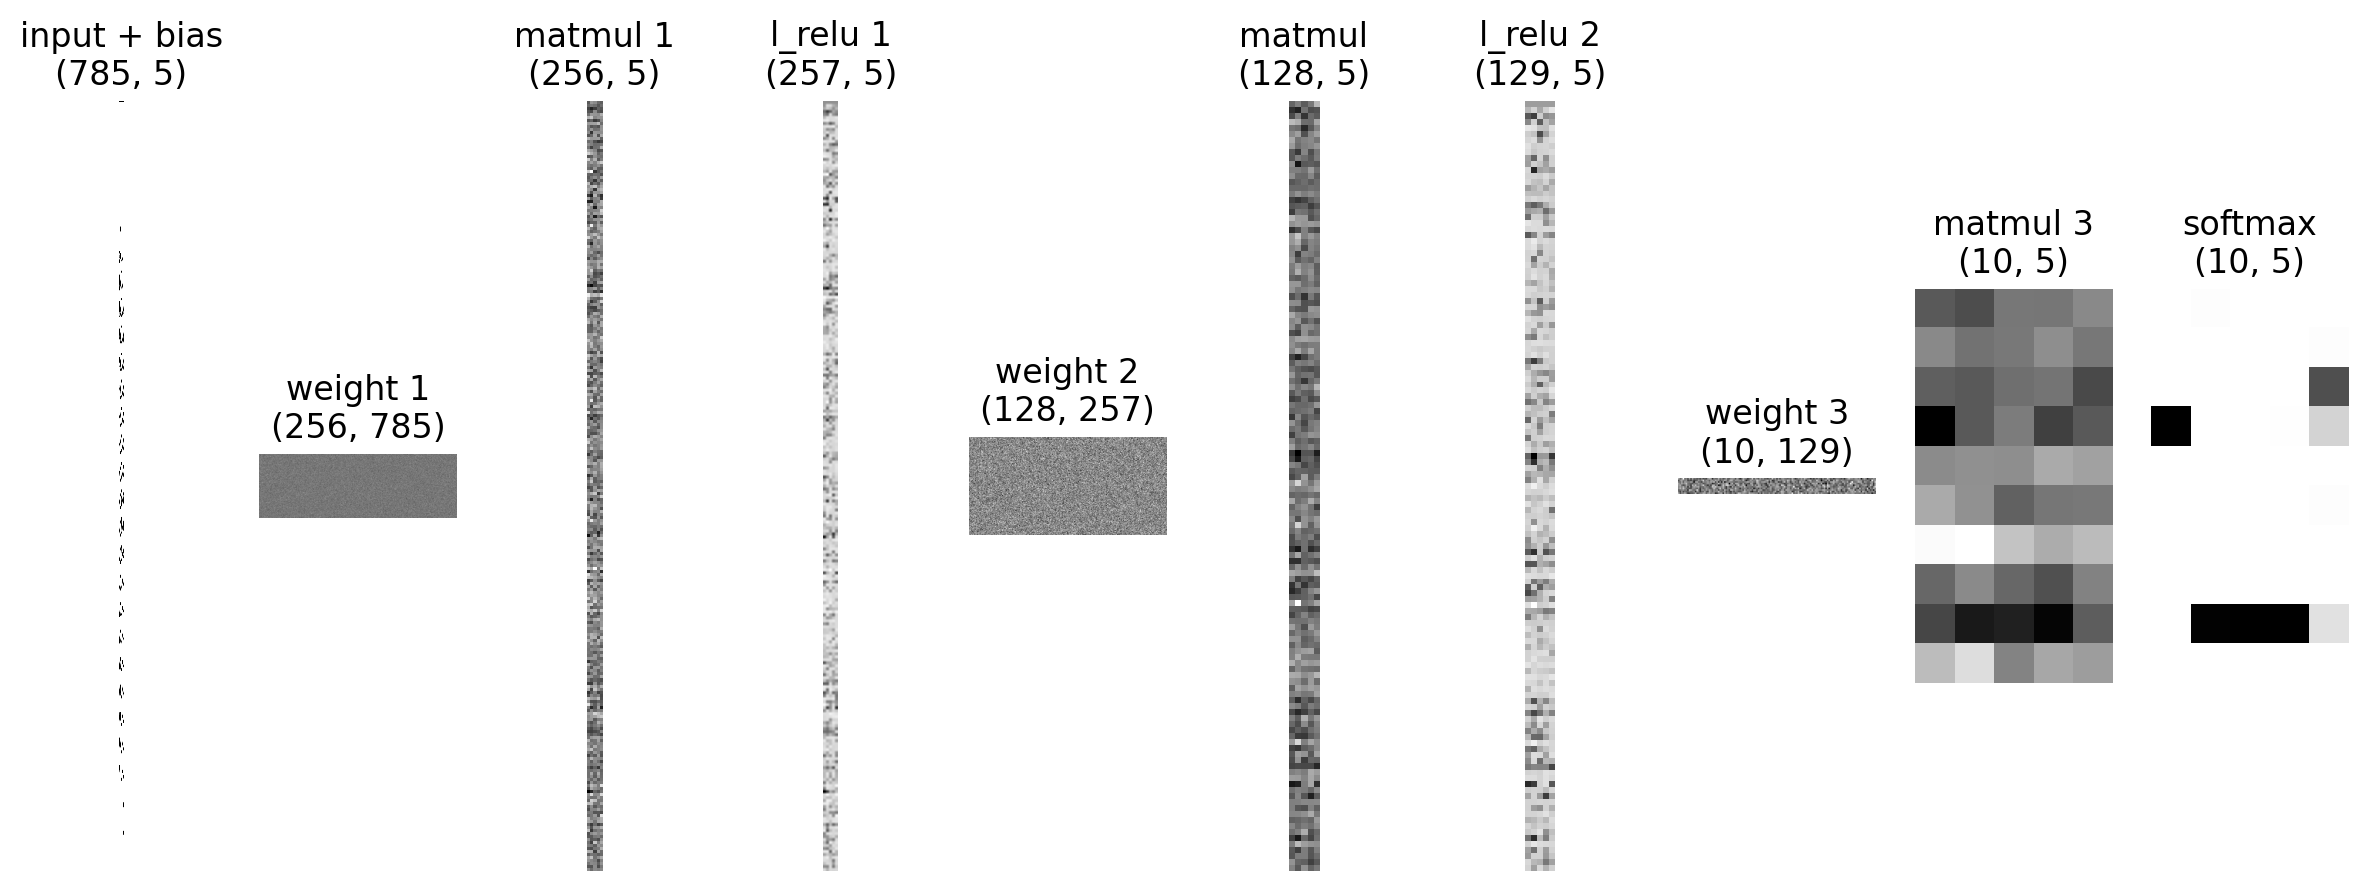

true values: [5 0 4 1 9]
predicted values: [3 8 8 8 2]


In [22]:
a1, z2, a2, z3, a3, z4, a4 = compute_forward_pass(sample, weights)

plot_layers(
    {
        "input + bias": a1,
        "weight 1": weights[0],
        "matmul 1": z2,
        "l_relu 1": a2,
        "weight 2": weights[1],
        "matmul": z3,
        "l_relu 2": a3,
        "weight 3": weights[2],
        "matmul 3": z4,
        "softmax": a4,
    }
)

print(f"true values: {label}")
print(f"predicted values: {np.argmax(a4, axis=0)}")


## Backwardpass is in construction 🔨